# AEBS
Demonstration of `AEJxLPS_2F` and `AEJxPBS_2F`(TBD) product.

In [1]:
from viresclient import SwarmRequest
from viresclient._wps.time_util import parse_datetime

SPACECRAFT = "A"
TIME = "2015-06-02T00:00:00Z"

SwarmRequest.COLLECTIONS.update({
    "AEJ_LPS": ["SW_OPER_AEJ{}LPS_2F".format(x) for x in "ABC"],
    "AEJ_PBS": ["SW_OPER_AEJ{}PBS_2F".format(x) for x in "ABC"],
})

SwarmRequest.PRODUCT_VARIABLES.update({
    "AEJ_LPS": [
        "Latitude_QD", "Longitude_QD", "MLT_QD",
        "J_CF", "J_DF", "J_CF_SemiQD", "J_DF_SemiQD", "J_C"
    ],
    "AEJ_PBS": ["Latitude_QD", "Longitude_QD", "MLT_QD", "Flags", "PointType"],
})

try:
    request = SwarmRequest("https://staging.viresdisc.vires.services/ows")

    orbit_number = request.get_orbit_number(SPACECRAFT, parse_datetime(TIME))
    start_time, end_time =  request.get_times_for_orbits(SPACECRAFT, orbit_number, orbit_number)
    print("Orbit number: %s:%s" % (SPACECRAFT, orbit_number))
    print("Start time:  ", start_time)
    print("End time:    ", end_time)
    
    # retrieve latitude profiles
    request.set_collection("SW_OPER_AEJ%sLPS_2F" % SPACECRAFT)
    request.set_products(
        measurements=['Latitude_QD', 'Longitude_QD', 'MLT_QD', 'J_CF', 'J_DF', 'J_CF_SemiQD', 'J_DF_SemiQD', 'J_C'],
        auxiliaries=['QDOrbitDirection', 'OrbitNumber'],
        sampling_step="PT1S",       # 1 second sampling
    )
    response = request.get_between(
        start_time=start_time,
        end_time=end_time,
    )
    print("Sources:\n\t%s" % "\n\t".join(response.sources))
    profile = response.as_xarray()
    
    # retrieve peeks and boundaries
    request.set_collection("SW_OPER_AEJ%sPBS_2F" % SPACECRAFT)
    request.set_products(
        measurements=['Latitude_QD', 'Longitude_QD', 'MLT_QD', 'Flags', 'PointType'],
        auxiliaries=['QDOrbitDirection', 'OrbitNumber'],
        sampling_step="PT1S",       # 1 second sampling
    )
    response = request.get_between(
        start_time=start_time,
        end_time=end_time,
    )
    print("Sources:\n\t%s" % "\n\t".join(response.sources))
    boundaries = response.as_xarray()

except Exception as error:
    print("ERROR: ", error)
else:
    print(profile)
    print(boundaries)

[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Orbit number: A:8528
Start time:   2015-06-01 23:46:18.406025
End time:     2015-06-02 01:19:59.576380


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.303MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Sources:
	SW_OPER_AEJALPS_2F_20150601T000000_20150601T235959_0101
	SW_OPER_AEJALPS_2F_20150602T000000_20150602T235959_0101
	SW_OPER_AUXAORBCNT_20131122T000000_20200220T000000_0001
	SW_OPER_AUX_IMF_2__20150101T000000_20150630T230000_0001
	SW_OPER_MAGA_LR_1B_20150601T000000_20150601T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150602T000000_20150602T235959_0505_MDR_MAG_LR


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.097MB)


Sources:
	SW_OPER_AEJAPBS_2F_20150101T000000_20151231T235959_0101
	SW_OPER_AUXAORBCNT_20131122T000000_20200220T000000_0001
	SW_OPER_AUX_IMF_2__20150101T000000_20150630T230000_0001
	SW_OPER_MAGA_LR_1B_20150602T000000_20150602T235959_0505_MDR_MAG_LR
<xarray.Dataset>
Dimensions:           (J_CF_dim1: 2, J_DF_dim1: 2, Timestamp: 2504)
Coordinates:
  * Timestamp         (Timestamp) datetime64[ns] 2015-06-01T23:59:42 ... 2015-06-02T01:09:03
Dimensions without coordinates: J_CF_dim1, J_DF_dim1
Data variables:
    Spacecraft        (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    Latitude_QD       (Timestamp) float64 50.02 50.08 50.15 ... -50.04 -49.98
    J_CF              (Timestamp, J_CF_dim1) float64 -12.51 -2.537 ... -1.705
    Longitude_QD      (Timestamp) float64 -102.0 -102.1 -102.1 ... -104.2 -104.2
    J_C               (Timestamp) float64 -0.04176 -0.04176 ... 8.271e-05
    OrbitNumber       (Timestamp) int32 8528 8528 8528 8528 ... 8528 8528 8528
    Longitude        

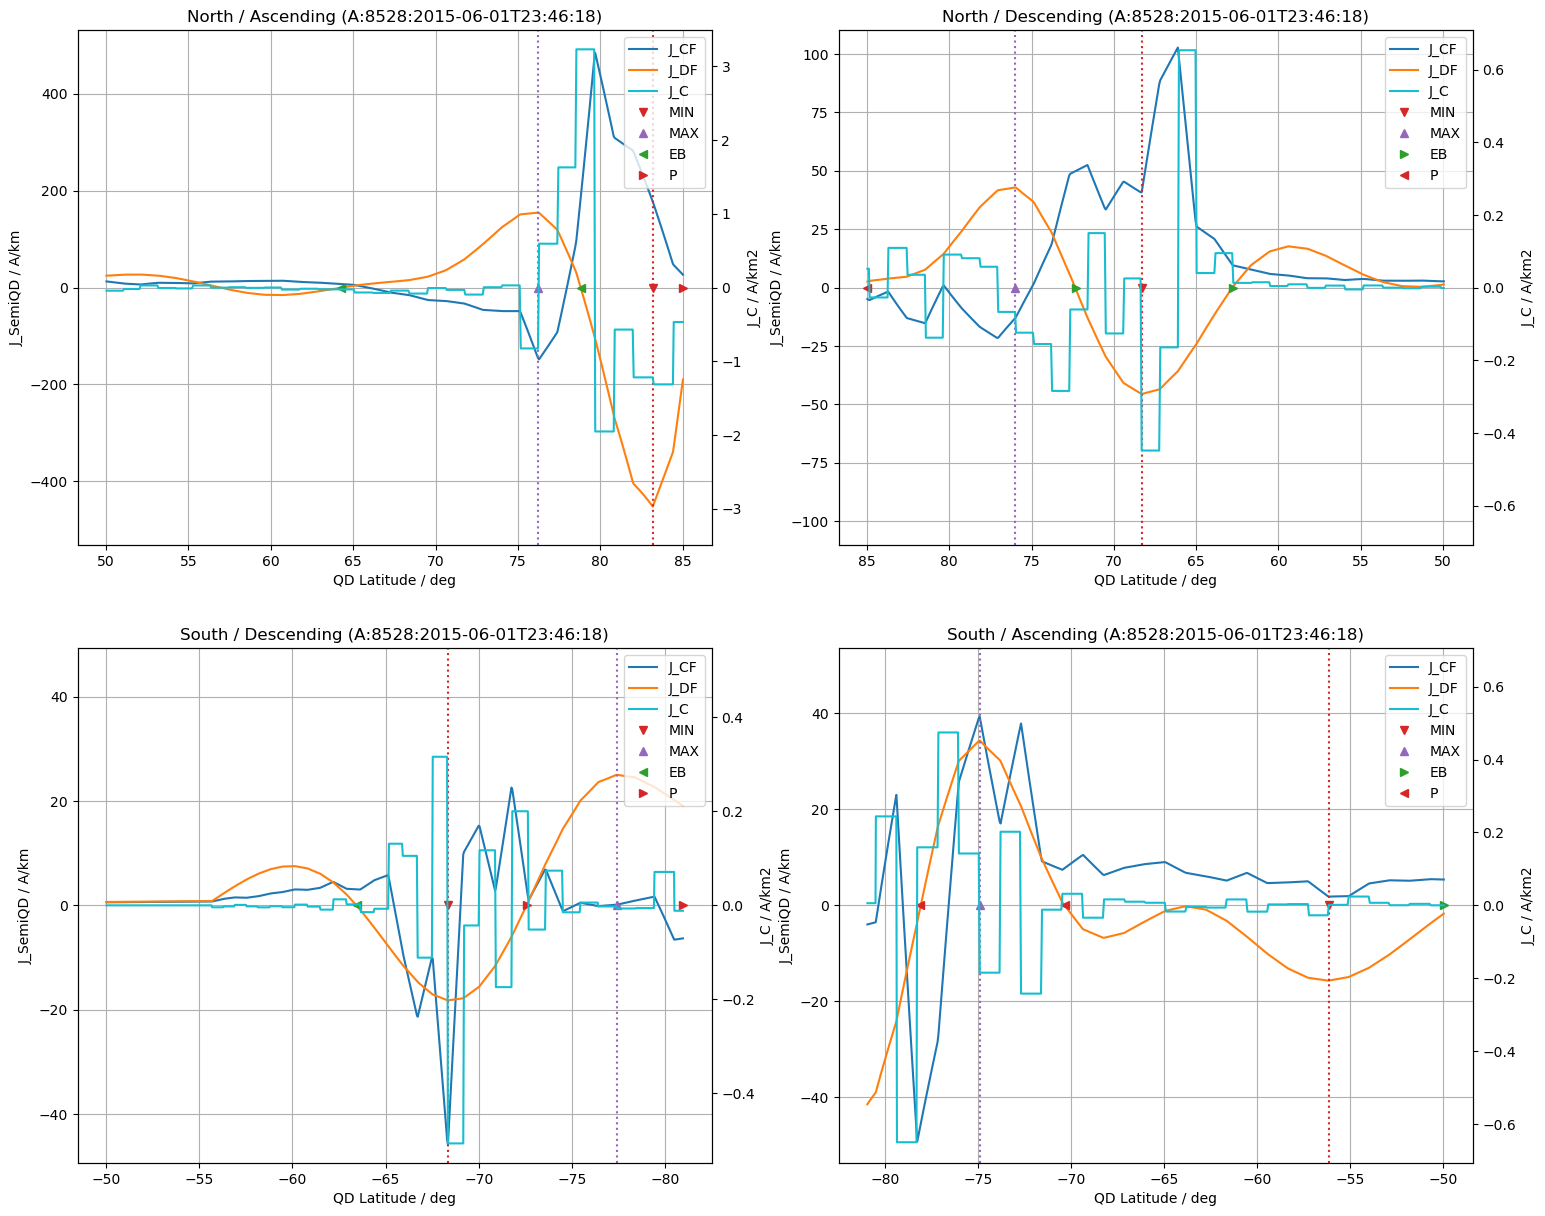

In [2]:
from numpy import isnan, logical_and, abs as aabs, zeros
from matplotlib.pyplot import figure, subplot, show
%matplotlib inline

# point types
EB0 = 0x0       # Equatorial Boundary 0 (WEJ?)
EB1 = 0x1       # Equatorial Boundary 1 (EEJ?)
PB0 = 0x2       # Polar Boundary 0 (WEJ?)
PB1 = 0x3       # Polar Boundary 1 (EEJ?)
PEAK_MIN = 0x4  # Peak - Minimum of J_QD
PEAK_MAX = 0x5  # Peak - Maximum of J_QD


def get_quadrant_mask(data, ascending, north):
    orbit_direction = data["QDOrbitDirection"].values
    latitude = data["Latitude_QD"].values
    return logical_and(
        (orbit_direction > 0 if ascending else orbit_direction < 0),
        (latitude > 0 if north else latitude < 0)
    )


def format_time(time):
    return time.replace(microsecond=0).isoformat()


def get_title(ascending, north):
    pass_ = "Ascending" if ascending else "Descending"
    hemisphere = "North" if north else "South"
    return "%s / %s (%s:%s:%s)" % (hemisphere, pass_, SPACECRAFT, orbit_number, format_time(start_time))


def plot(ax, ascending, north):
    p_mask = get_quadrant_mask(profile, ascending=ascending, north=north)
    b_mask = get_quadrant_mask(boundaries, ascending=ascending, north=north)
    l_cf, = ax.plot(p_qd_latitude[p_mask], p_qd_j_cf[p_mask], label="J_CF")
    l_df, = ax.plot(p_qd_latitude[p_mask], p_qd_j_df[p_mask], label="J_DF")
    ax.grid()
    ax.set_title(get_title(ascending=ascending, north=north))
    ax.set_xlabel('QD Latitude / deg')
    ax.set_ylabel('J_SemiQD / A/km')
    
    x = b_qd_latitude[b_mask&(point_type&0x6==0x0)]; l_eb, = ax.plot(x, zeros(x.shape), '<' if north==ascending else '>')
    x = b_qd_latitude[b_mask&(point_type&0x6==0x2)]; l_pb, = ax.plot(x, zeros(x.shape), '>' if north==ascending else '<')
    x = b_qd_latitude[b_mask&(point_type==0x4)]; l_min, = ax.plot(x, zeros(x.shape), 'v', color='tab:red')
    x = b_qd_latitude[b_mask&(point_type==0x5)]; l_max, = ax.plot(x, zeros(x.shape), '^', color='tab:purple')
    
    if not ascending:
        xmin, xmax = ax.get_xlim(); ax.set_xlim((xmax, xmin)) # flip x axis
    ymax = aabs(ax.get_ylim()).max(); ax.set_ylim((-ymax, ymax)) # center y axis around 0
    
    # boundaries
    for x in b_qd_latitude[b_mask&(point_type==0x4)]:
        ax.plot([x, x], [-ymax, ymax], ':', color='tab:red')
    for x in b_qd_latitude[b_mask&(point_type==0x5)]:
        ax.plot([x, x], [-ymax, ymax], ':', color='tab:purple')

    ax = ax.twinx()
    l_c, = ax.plot(p_qd_latitude[p_mask], p_qd_j_c[p_mask], label="J_C", color="tab:cyan")
    ax.set_ylabel('J_C / A/km2')
    ax.legend((l_cf, l_df, l_c, l_min, l_max, l_eb, l_pb), ('J_CF', 'J_DF', 'J_C', 'MIN', 'MAX', 'EB', 'P' ))
    
    ymax = aabs(ax.get_ylim()).max(); ax.set_ylim((-ymax, ymax))    


p_qd_latitude = profile["Latitude_QD"].values
p_qd_j_cf = profile["J_CF_SemiQD"].values
p_qd_j_df = profile["J_DF_SemiQD"].values
p_qd_j_c = profile["J_C"].values

b_qd_latitude = boundaries["Latitude_QD"].values
point_type = boundaries["PointType"].values

fig = figure(figsize=(18, 15), dpi=100)

plot(subplot(221), ascending=True, north=True)
plot(subplot(222), ascending=False, north=True)
plot(subplot(223), ascending=False, north=False)
plot(subplot(224), ascending=True, north=False)

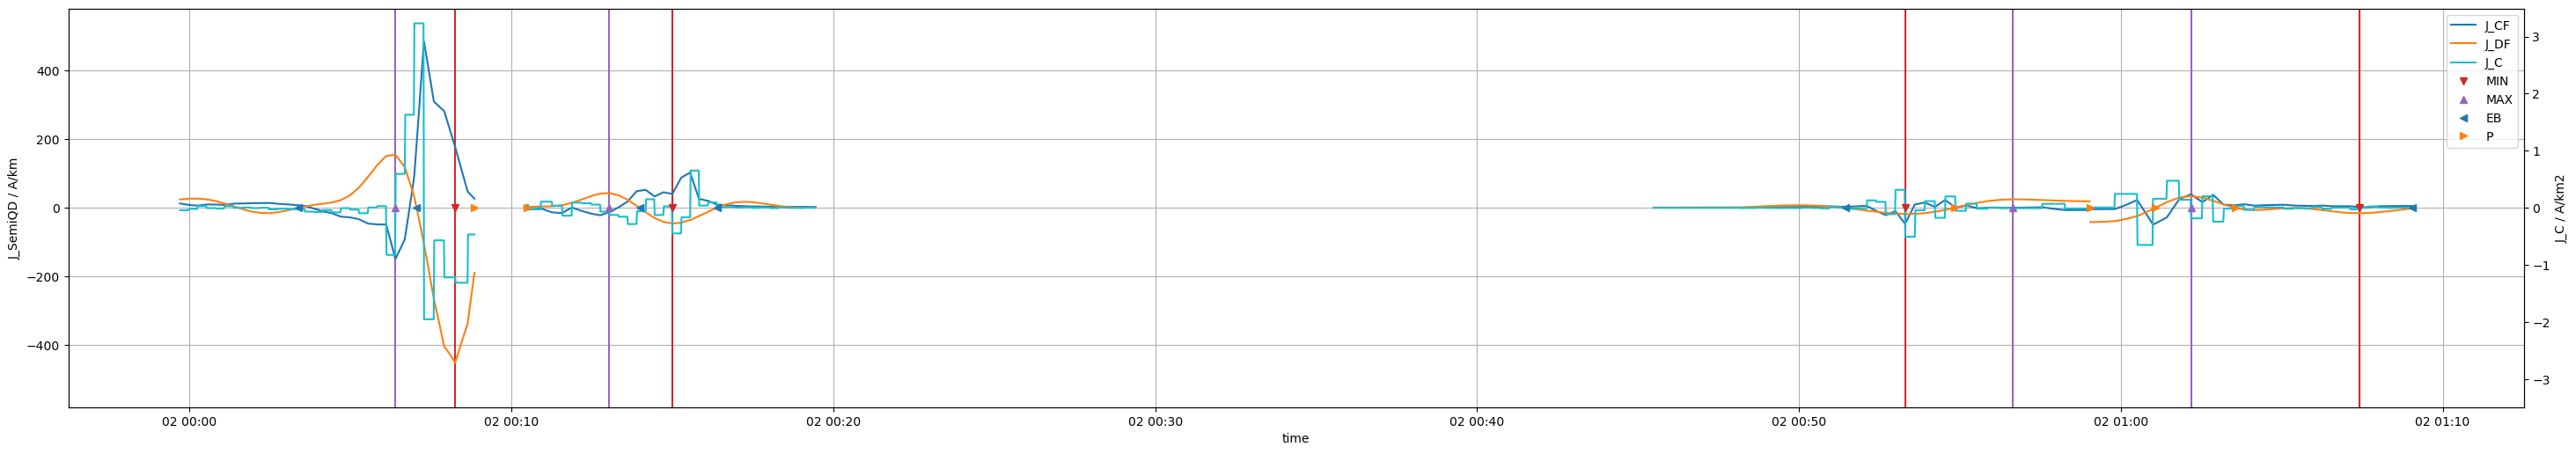

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

p_time = profile["Timestamp"].values
p_qd_j_cf = profile["J_CF_SemiQD"].values
p_qd_j_df = profile["J_DF_SemiQD"].values
p_qd_j_c = profile["J_C"].values

b_time = boundaries["Timestamp"].values
point_type = boundaries["PointType"].values

def plot(ax):
    
    ymax = 1.2 * max(aabs(p_qd_j_cf).max(), aabs(p_qd_j_cf).max())
    # boundaries
    for x in b_time[(point_type==0x4)]:
        ax.plot([x, x], [-ymax, ymax], '-', color='tab:red')
    for x in b_time[(point_type==0x5)]:
        ax.plot([x, x], [-ymax, ymax], '-', color='tab:purple')
    
    def _plot(ascending, north):
        p_mask = get_quadrant_mask(profile, ascending=ascending, north=north)
        l_cf, = ax.plot(p_time[p_mask], p_qd_j_cf[p_mask], '-', markersize=4, label="J_CF", color='tab:blue')
        l_df, = ax.plot(p_time[p_mask], p_qd_j_df[p_mask], '-', markersize=4, label="J_DF", color='tab:orange')
        return l_cf, l_df
    
    l_cf, l_df = _plot(ascending=True, north=True)
    l_cf, l_df = _plot(ascending=False, north=True)
    l_cf, l_df = _plot(ascending=False, north=False)
    l_cf, l_df = _plot(ascending=True, north=False)
    ax.grid()
    
    ax.set_xlabel('time')
    ax.set_ylabel('J_SemiQD / A/km')

    
    #ymax = aabs(ax.get_ylim()).max();
    ax.set_ylim((-ymax, ymax)) # center y axis around 0
    
    ax = ax.twinx()
    
    def _plot(ascending, north):
        p_mask = get_quadrant_mask(profile, ascending=ascending, north=north)
        l_c, = ax.plot(p_time[p_mask], p_qd_j_c[p_mask], '-', markersize=4, label="J_C", color="tab:cyan")
        return l_c
    
    l_c = _plot(ascending=True, north=True)
    l_c = _plot(ascending=False, north=True)
    l_c = _plot(ascending=False, north=False)
    l_c = _plot(ascending=True, north=False)

    x = b_time[(point_type&0x6==0x0)]; l_eb, = ax.plot(x, zeros(x.shape), '<')
    x = b_time[(point_type&0x6==0x2)]; l_pb, = ax.plot(x, zeros(x.shape), '>')
    x = b_time[(point_type==0x4)]; l_min, = ax.plot(x, zeros(x.shape), 'v', color='tab:red')
    x = b_time[(point_type==0x5)]; l_max, = ax.plot(x, zeros(x.shape), '^', color='tab:purple')

    ax.set_ylabel('J_C / A/km2')
    ax.legend((l_cf, l_df, l_c, l_min, l_max, l_eb, l_pb), ('J_CF', 'J_DF', 'J_C', 'MIN', 'MAX', 'EB', 'P' ))

    #if not ascending:
    #    xmin, xmax = ax.get_xlim(); ax.set_xlim((xmax, xmin)) # flip x axis
    ymax = aabs(ax.get_ylim()).max(); ax.set_ylim((-ymax, ymax)) # center y axis around 0

fig = figure(figsize=(36, 6), dpi=100)
plot(subplot(1, 1, 1))